## Simulating beam-coupling impedance and wakefields
### The CERN-LHC bellows example

In this demonstration notebook, the theory behing the numerical calculation of electromagnetic wakefields will be introduced with the example of a **real** element: the **LHC bellows**.

The bellows are vacuum components installed between rigid beampipe sections to accomodate thermal expansion and decouple mechanical stresses. They are thin-wall corrugated elements, presenting convolutions that grant them flexibility.

Due to the convolutions, they are electromagnetically non-smooth, having therefore a considerable impact on beam-coupling impedance.


<div style="text-align:center">
  <img src="data/lhcbellow.png" width="600">
</div>


### Tools to use:

There are several codes to compute beam-coupling impedance: in time-domain or frequency domain, numerical or semi-analytical, co-moving window or resting frame... To perform full-wave 3D simulations on arbitrary geometry and materials, the reference code is the commercial CST Studio Wakefield Solver.

In this demonstration we will use [Wakis](https://github.com/ImpedanCEI/wakis), a new open-source 3D electromagnetic code built in Python, that can perform full-wave 3D simulations solving the general form of Maxwell's Equations in time-domain:


<div style="text-align:center">
  <img src="data/wakesolver.png" width="600">
</div>

----

In [1]:
# Import required libraries for geometry, visualization, and simulation
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from wakis import SolverFIT3D
from wakis import GridFIT3D
from wakis import WakeSolver

pv.global_theme.window_size = [800, 400]
plot_pyvista = True

### Geometry import and generation of the simulation mesh

We will import the Bellow geometry stored in an STL file:

<div style="text-align:center">
  <img src="data/bellow-geometry.png" width="300">
</div>


In [2]:
# ---------- Domain & Mesh setup ---------
# Set up geometry & materials dictionaries
stl_file = 'data/bellow-vacuum-mm.stl'

# Domain bounds
bellow = pv.read(stl_file).scale(1e-3)
xmin, xmax, ymin, ymax, zmin, zmax = bellow.bounds

# Number of mesh cells
Nx = 100
Ny = 100
Nz = 200
print(f'Total number of mesh cells: {Nx*Ny*Nz}')

# set grid and geometry
grid = GridFIT3D(*bellow.bounds,
                Nx, Ny, Nz,
                stl_solids={'bellow': stl_file},
                stl_materials={'bellow': 'vacuum'},
                stl_scale = 1e-3,
                )

grid.save_to_h5('grid.h5')

# visualize grid
if plot_pyvista:
    grid.inspect()

Total number of mesh cells: 2000000
Generating grid with 2000000 mesh cells...
Importing STL solids...
Total grid initialization time: 21.599705934524536 s
Saving grid to HDF5 file: grid.h5


Widget(value='<iframe src="http://localhost:42103/index.html?ui=P_0x7fae80619700_0&reconnect=auto" class="pyvi…

 JS Error => instance deleted - cannot call any method
 JS Error => instance deleted - cannot call any method


### Definition of electromagnetic problem

With the electromagnetic solver, we will numerically solve Maxwell's Equations using the Finite Integration Technique:

<div style="text-align:center">
  <img src="data/Maxwell's-Eq.png" width="400">
</div>

With a passing beam current modeled as a Gaussian distribution:

$$
\mathbf{J}_z(x_{\text{src}}, y_{\text{src}}, \vec{z}, t) \equiv \lambda(s) =
\frac{q \beta c}{\sqrt{2\pi} \sigma_z} \, 
\exp\left( -\frac{(\vec{s} - s_0)^2}{2\sigma_z^2} \right)
$$

with:
- $\vec{s} = \vec{z} - \beta c t$: beam-frame coordinate
- $s_0 = z_{\min} - \beta c t_{\text{inj}}$: center of bunch
- $q$ the charge in $\text{nC}$
- $\sigma_z$ the bunch length in $\text{m}$


In [3]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 40e-3      #[m] 50mm -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta
xs = 0.             # x source position [m]
ys = 5e-3           # y source position [m] --> Dipolar Y
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
skip_cells = 40     # no. cells to skip from wake integration
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s]

# ----------- Wakefield integration  ----------
# Wakefield post-processor
wakelength = 10. # [m]

results_folder = 'results/'
wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys,
                xtest=xt, ytest=yt,
                skip_cells=skip_cells,
                wakelength=wakelength,
                results_folder=results_folder,
                Ez_file=results_folder+'Ez.h5',)

# ----------- Solver setup  ----------
# boundary conditions
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

solver = SolverFIT3D(grid, wake,
                     bc_low=bc_low, bc_high=bc_high,
                     use_stl=True,
                     use_gpu=False,
                     use_mpi=False,
                     bg='pec',  # background material
                     dtype=np.float32, #or float64 for double-precision
                     )

if plot_pyvista:
    solver.inspect()

Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Using MKL backend for time-stepping...
Total solver initialization time: 3.119985580444336 s


Widget(value='<iframe src="http://localhost:42103/index.html?ui=P_0x7fae5a5c2bd0_1&reconnect=auto" class="pyvi…

### Running the electromagnetic simulation

By computing the fields in time-domain, we can integrate them to obtain the wakefields and impedance:

$$
W(s) = \frac{1}{q_s} \int_{-\infty}^{\infty} \left[ E_z(z, t) + \beta c \, \vec{e}_z \times \vec{B}(z, t) \right]_{t = (s + z)/c} \, dz
$$


The wakefield is the input to beam-dynamics simulations. Its Fourier transform yields the **beam-coupling impedance**, in frequency domain:

$$
Z(\omega) = \beta c \cdot \frac{\mathcal{F}[W(s)]}{\mathcal{F}[\lambda(s)]}
$$

In [4]:
os.makedirs('img', exist_ok=True)

plotkw = {'title':'img/Ez',
         'field': 'Ez',
         'clim' : [-400, 400]
         }

if os.path.exists(results_folder+'Ez.h5'):
    print('Loading existing results...')
    wake.load_results(results_folder)
else:
    solver.wakesolve(wakelength=wakelength,
                    wake=wake,
                    plot=True,
                    plot_func=solver.plot3DonSTL,
                    plot_from=1000,
                    plot_every=50,
                    plot_until=5000,
                    **plotkw)

Loading existing results...


#### Visualize the electromagnetic wakefields

In [ ]:
!convert -loop 0 -delay 10 img/*.png Ez.gif

![](Ez.gif)

#### Plot the computed wakefields and impedance:

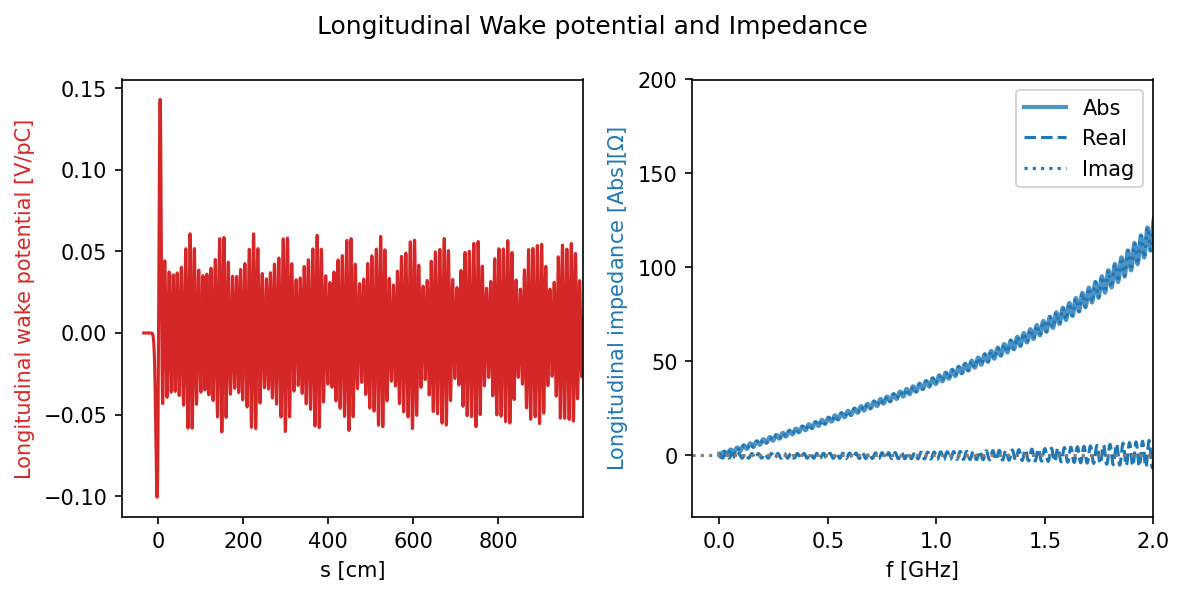

In [6]:
# Plot longitudinal wake potential and impedance: WP(s), Z(f)

fig1, ax = plt.subplots(1,2, figsize=[8,4], dpi=150)

ax[0].plot(wake.s*1e2, wake.WP, c='tab:red', lw=1.5, )
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].set_xlim(xmax=wake.wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='tab:blue', alpha=0.8, lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='--', c='tab:blue', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), ls=':', c='tab:blue', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].axhline(0, ls=':', c='grey')
ax[1].set_ylabel(r'Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].set_xlim(xmax=2)
ax[1].set_ylim(ymax=200)
ax[1].legend()

fig1.suptitle('Longitudinal Wake potential and Impedance')
fig1.tight_layout()

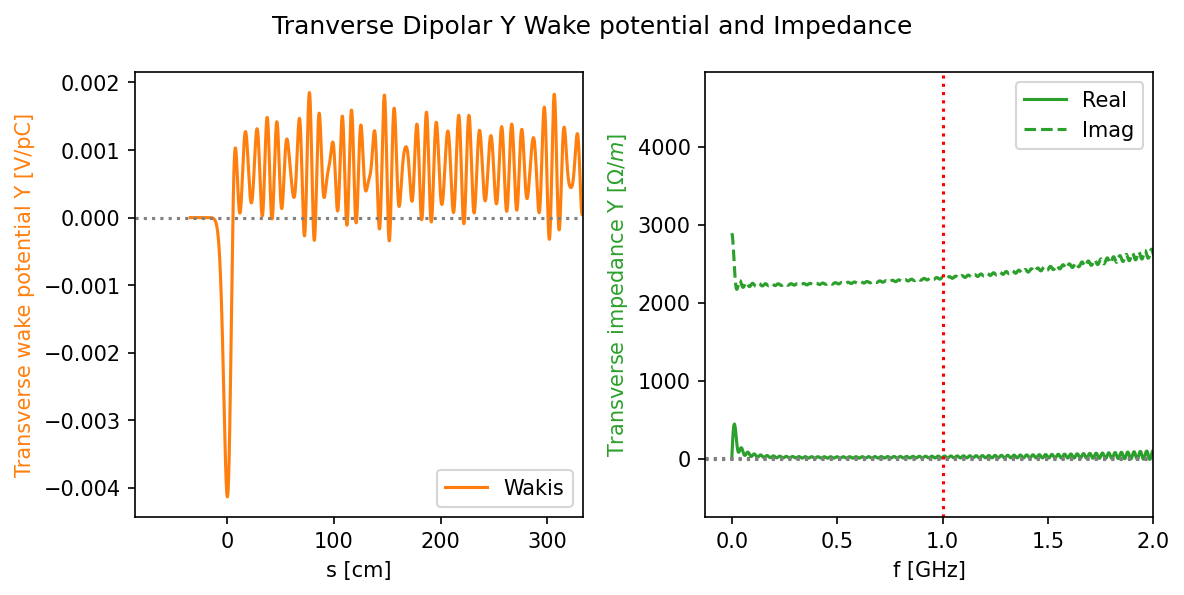

In [7]:
# Plot transverse Dipolar Y: WPy(s), Zy(f)

fig2, ax = plt.subplots(1,2, figsize=[8,4], dpi=150)

ax[0].plot(wake.s*1e2, wake.WPy, c='tab:orange', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential Y [V/pC]', color='tab:orange')
ax[0].legend()
ax[0].axhline(0, ls=':', c='grey')
ax[0].set_xlim(xmax=wake.wakelength*1e2/3)

#ax[1].plot(wake.f*1e-9, np.abs(wake.Zy), c='tab:green', lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Zy)/ys, c='tab:green', ls='-', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zy)/ys, c='tab:green', ls='--', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel(r'Transverse impedance Y [$\Omega/m$]', color='tab:green')
ax[1].legend()
ax[1].axhline(0, ls=':', c='grey')
ax[1].axvline(1, ls=':', c='red')
ax[1].axhline(15, ls=':', c='grey')
ax[1].set_xlim(xmax=2)

fig2.suptitle('Tranverse Dipolar Y Wake potential and Impedance')
fig2.tight_layout()

-----

## Optimizing impedance of the LHC Bellows

### Parametric scans on number of convolutions

To try to reduce the impedance of the bellows, we could play with the construction parameters, such as:
* The number of convolutions
* The depth of the convolutions
* The radius of the bellow drum

However, this only gives a weak linear dependency, and there is not much flexibility to adjust these numbers:


<div style="text-align:center">
  <img src="data/parametric-study.png" width="700">
</div>

> *See the EXTRA section at the end to run parametric cases yourself!*

### Adding RF shielding

A solution that has been adopted in the LHC is the inclusion of RF fingers that ensure electromagnetic continuity of the beampipe, minimizing the imaginary dipolar impedance contribution:

<div style="text-align:center">
  <img src="data/shield.png" width="700">
</div>

> *We can simulate this now with Wakis!*

In [36]:
# Import required libraries for geometry, visualization, and simulation
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from wakis import SolverFIT3D
from wakis import GridFIT3D
from wakis import WakeSolver

pv.global_theme.window_size = [800, 400]
plot_pyvista = True

In [38]:
# ---------- Domain & Mesh setup ---------
# Set up geometry & materials dictionaries
stl_solids = {'bellow': 'data/bellow-vacuum-mm.stl',
              'shield': 'data/shield-PEC-mm.stl'
             }

stl_materials = {'bellow': 'vacuum',
                 'shield': 'pec', # We add the shield STL!
                }

# Domain bounds
bellow = pv.read(stl_solids['bellow']).scale(1e-3)
xmin, xmax, ymin, ymax, zmin, zmax = bellow.bounds

# Number of mesh cells
Nx = 100
Ny = 100
Nz = 200

# set grid and geometry
grid = GridFIT3D(load_from_h5='grid_with_shield.h5',
                #*bellow.bounds,
                #Nx, Ny, Nz,
                #stl_solids=stl_solids,
                #stl_materials=stl_materials,
                #stl_scale = 1e-3,
                )

#grid.save_to_h5('grid_with_shield.h5')


# ------------ Beam source ----------------
# Beam parameters
sigmaz = 40e-3      #[m] 50mm -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta
xs = 0.             # x source position [m]
ys = 5e-3          # y source position [m] --> Dipolar Y
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
skip_cells = 40     # no. cells to skip from wake integration
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s]

# ----------- Wakefield integration  ----------
# Wakefield post-processor
wakelength = 10. # [m]

results_folder = 'results_with_shield/'
wake_shielded = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys,
                xtest=xt, ytest=yt,
                skip_cells=skip_cells,
                wakelength=wakelength,
                results_folder=results_folder,
                Ez_file=results_folder+'Ez.h5',)

# ----------- Solver setup  ----------
# boundary conditions
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']


solver = SolverFIT3D(grid, wake,
                     bc_low=bc_low, bc_high=bc_high,
                     use_stl=True,
                     use_gpu=False,
                     use_mpi=False,
                     bg='pec',  # background material
                     dtype=np.float32,
                     )

if plot_pyvista:
    solver.inspect(add_silhouette=True)

Loading grid from HDF5 file: grid_with_shield.h5
Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Using MKL backend for time-stepping...
Total solver initialization time: 2.9070632457733154 s


Widget(value='<iframe src="http://localhost:42103/index.html?ui=P_0x7fae006fffb0_3&reconnect=auto" class="pyvi…

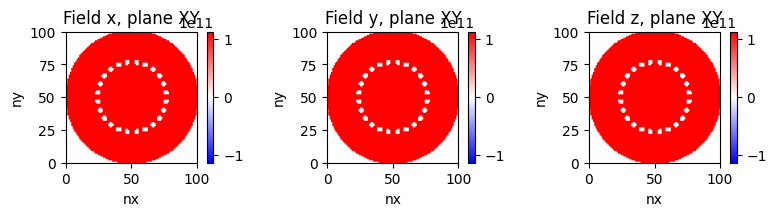

In [12]:
solver.ieps.inspect(plane='XY')

In [30]:
if os.path.exists(results_folder+'Ez.h5'):
    print('Loading existing results...')
    wake_shielded.load_results(results_folder)
else:
    solver.wakesolve(wakelength=wakelength,
                    wake=wake_shielded,
                    plot=False)

Loading existing results...


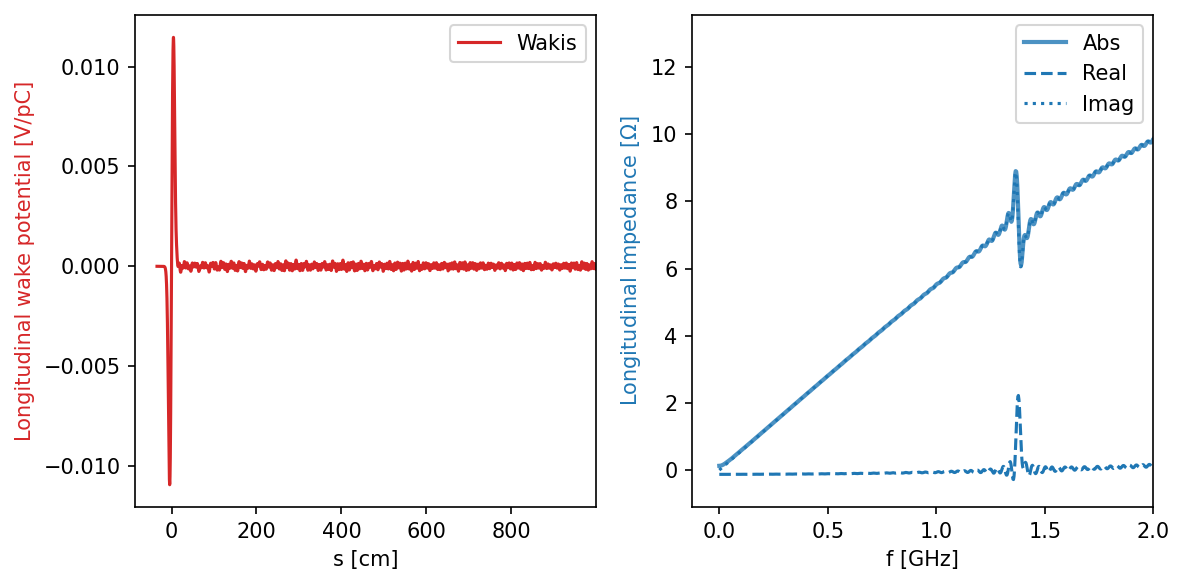

In [31]:
# Plot longitudinal wake potential and impedance: WP(s), Z(f)
fig1, ax = plt.subplots(1,2, figsize=[8,4], dpi=150)

ax[0].plot(wake_shielded.s*1e2, wake_shielded.WP, c='tab:red', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()
ax[0].set_xlim(xmax=wake_shielded.wakelength*1e2)

ax[1].plot(wake_shielded.f*1e-9, np.abs(wake_shielded.Z), c='tab:blue', alpha=0.8, lw=2, label='Abs')
ax[1].plot(wake_shielded.f*1e-9, np.real(wake_shielded.Z), ls='--', c='tab:blue', lw=1.5, label='Real')
ax[1].plot(wake_shielded.f*1e-9, np.imag(wake_shielded.Z), ls=':', c='tab:blue', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_xlim(xmax=2)
ax[1].set_ylabel(r'Longitudinal impedance [$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()

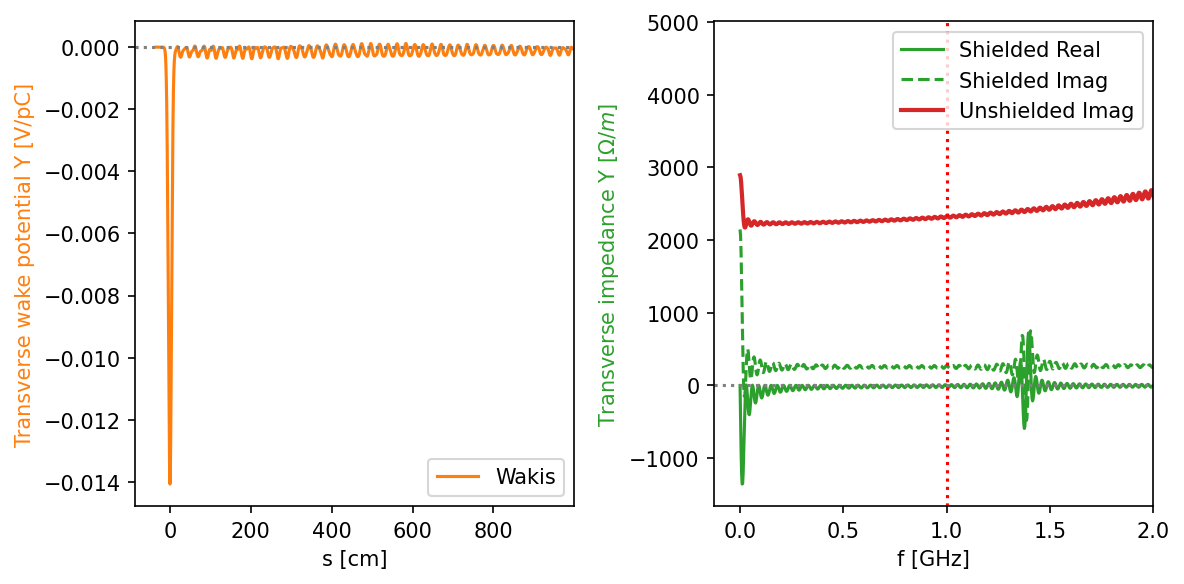

In [35]:
# Plot transverse Dipolar Y: WPy(s), Zy(f)

fig2, ax = plt.subplots(1,2, figsize=[8,4], dpi=150)

ax[0].plot(wake_shielded.s*1e2, wake_shielded.WPy, c='tab:orange', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential Y [V/pC]', color='tab:orange')
ax[0].legend()
ax[0].axhline(0, ls=':', c='grey')
ax[0].set_xlim(xmax=wake_shielded.wakelength*1e2)

ax[1].plot(wake_shielded.f*1e-9, np.real(wake_shielded.Zy)/ys, c='tab:green', ls='-', lw=1.5, label='Shielded Real')
ax[1].plot(wake_shielded.f*1e-9, -np.imag(wake_shielded.Zy)/ys, c='tab:green', ls='--', lw=1.5, label='Shielded Imag')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zy)/ys, c='tab:red', ls='-', lw=2, label='Unshielded Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel(r'Transverse impedance Y [$\Omega/m$]', color='tab:green')
ax[1].legend()
ax[1].axhline(0, ls=':', c='grey')
ax[1].axvline(1, ls=':', c='red')
ax[1].set_xlim(xmax=2)

fig2.tight_layout()

## Conclusions

<div style="text-align:center">
  <img src="data/conclusion.png" width="800">
</div>

### [EXTRA] Parametric scans:

One can generate the geometry direcly from Python to perform parametric scans on the different bellow construction paramters & verify the results shown in the previous section!

In [ ]:
# --- Generate beam pipe geometry ---
r_pipe = 24e-3      # Pipe radius in metersm
l_pipe = 320e-3     # Pipe length in metersth in meters

# --- Generate bellow convolutions ---
r_conv = 30e-3              # convolution radius [m]
l_conv = 4e-3               # length of each convolution [m]
n_convs = [25, 18, 15]      # number of convolutions
l_between_conv = 4e-3       # length between convolutions [m]

# Parametric generation of geometry
def generate_geometry(n_conv=n_convs,
                    r_conv=r_conv,
                    l_conv=l_conv,
                    l_between_conv=l_between_conv,
                    save_to_STL=True,
                    ):

    print(f'Generating bellow with {n_conv} convolutions...')

    # Convolutions generation
    convolutions = []
    z_start = n_conv//2*(l_conv + l_between_conv) - l_conv # start of the convolutions [m]
    for n in range(n_conv):
        z_start_n_conv = -z_start+n*(l_conv+l_between_conv)
        conv = pv.Cylinder(center=(0,0,z_start_n_conv), # center of the convolution
                        direction=(0,0,1),           # z-direction
                        radius=r_conv,
                        height=l_conv)
        convolutions.append(conv)                       # append to list

    # Sum the generated geometry
    pipe = pv.Cylinder(center=(0,0,0), direction=(0,0,1), radius=r_pipe, height=l_pipe)
    pipe = pipe.triangulate()                          # triangulate pipe
    convolutions = np.sum(convolutions).triangulate()  # triangulate convolutions
    bellow = pipe | convolutions  # union of meshes without internal faces
    if save_to_STL:
        bellow.save(f'data/{n_conv}_convolution_bellow.stl')  # save intermediate geometry
    return bellow

bellows = np.empty_like(n_convs)
for i, n_conv in enumerate(n_convs):
    bellows[i] = generate_geometry(n_conv)

if plot_pyvista:
    pl = pv.Plotter()
    pl.add_mesh(bellows[0], color='white', edge_color='black', label=f'{n_convs[0]} convolutions')
    pl.add_mesh(bellows[1].translate((0,-0.1,0)), color='white', edge_color='black', label=f'{n_convs[1]} convolutions')
    pl.add_mesh(bellows[2].translate((0,0.1,0)), color='white', edge_color='black', label=f'{n_convs[2]} convolutions')
    pl.show()